In [10]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import threading
import heapq
import time
from geopy.distance import geodesic

ox.settings.use_cache = True
ox.settings.log_console = False

⭐ Loading Ho Chi Minh City graph...


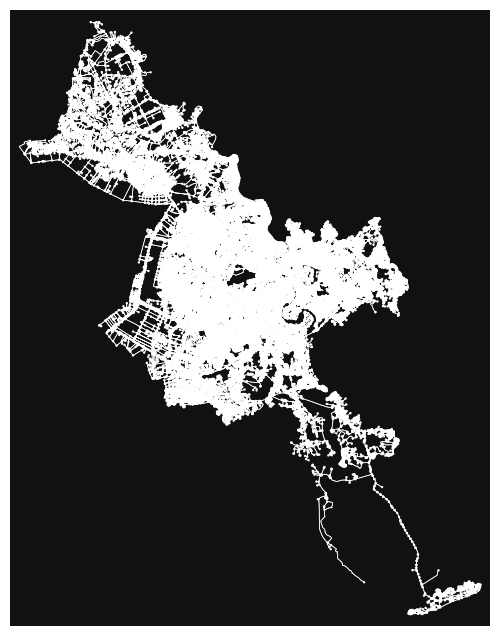

Start node: 366463208 (Thu Duc Market), Goal node: 2899065691 (Ben Thanh Market)


In [11]:
ox.settings.use_cache = True
ox.settings.log_console = False

# ---------- Load Ho Chi Minh City graph ----------
print("\u2b50 Loading Ho Chi Minh City graph...")
G = ox.graph_from_place('Ho Chi Minh City, Vietnam', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ox.plot_graph(G, node_size=3, edge_color='white', edge_linewidth=0.5)
plt.show()

# ---------- Define known locations ----------
start_gdf = ox.geocode_to_gdf('Thu Duc Market, Ho Chi Minh City')
if start_gdf.geometry.iloc[0].geom_type == 'Point':
    start_point = start_gdf.geometry.iloc[0]
else:
    start_point = start_gdf.geometry.iloc[0].centroid

goal_gdf = ox.geocode_to_gdf('Ben Thanh Market, Ho Chi Minh City')
if goal_gdf.geometry.iloc[0].geom_type == 'Point':
    goal_point = goal_gdf.geometry.iloc[0]
else:
    goal_point = goal_gdf.geometry.iloc[0].centroid

start_node = ox.distance.nearest_nodes(G, X=start_point.x, Y=start_point.y)
goal_node = ox.distance.nearest_nodes(G, X=goal_point.x, Y=goal_point.y)
print(f"Start node: {start_node} (Thu Duc Market), Goal node: {goal_node} (Ben Thanh Market)")


In [12]:
import sys
sys.path.append('./concurrent_set')  # tùy thuộc vào đường dẫn thư mục thực tế

from fine_grained_set import FineGrainedSet


In [13]:
class NodeWithPriority:
    def __init__(self, value, priority):
        self.value = value
        self.priority = priority
    
    def __lt__(self, other):  # để so sánh trong danh sách
        return self.priority < other.priority

class ConcurrentPriorityQueue:
    def __init__(self):
        self.lock = threading.Lock()
        self.heap = []

    def insert(self, node, priority):
        with self.lock:
            heapq.heappush(self.heap, (priority, node))

    def pop_min(self):
        with self.lock:
            if not self.heap:
                return None
            return heapq.heappop(self.heap)[1]

    def is_empty(self):
        with self.lock:
            return len(self.heap) == 0



In [14]:
def heuristic(a, b):
    coord_a = (G.nodes[a]['y'], G.nodes[a]['x'])
    coord_b = (G.nodes[b]['y'], G.nodes[b]['x'])
    return geodesic(coord_a, coord_b).meters

def parallel_a_star(G, start, goal, num_threads=4):
    open_set = ConcurrentPriorityQueue()
    open_set.insert(start, 0)
    
    g_score = {start: 0}
    f_score = {start: heuristic(start, goal)}
    came_from = {}
    visited = set()
    lock = threading.Lock()

    def worker():
        while not open_set.is_empty():
            with lock:
                current = open_set.pop_min()
            if current is None:
                return

            if current == goal:
                return

            for neighbor in G.successors(current):
                tentative_g = g_score.get(current, float('inf')) + G.edges[current, neighbor, 0].get("travel_time", 1)
                if tentative_g < g_score.get(neighbor, float('inf')):
                    with lock:
                        g_score[neighbor] = tentative_g
                        f_score[neighbor] = tentative_g + heuristic(neighbor, goal)
                        came_from[neighbor] = current
                        open_set.insert(neighbor, f_score[neighbor])

    threads = [threading.Thread(target=worker) for _ in range(num_threads)]
    for t in threads: t.start()
    for t in threads: t.join()

    return came_from

def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path


Parallel A* algorithm runtime: 0.36 seconds
Path found with 154 nodes.

Parallel A* path length: 17517.19 m, NetworkX path length: 12973.56 m
Length difference: 4543.62 m (35.02% difference)
Parallel A* path differs significantly from NetworkX shortest path.


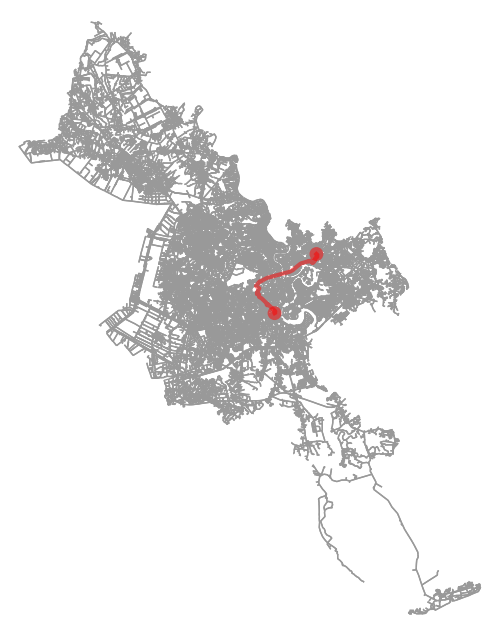

In [15]:


# ---------- Run Parallel A* ----------
start_time = time.time()
came_from = parallel_a_star(G, start_node, goal_node, num_threads=4)
end_time = time.time()
runtime = end_time - start_time
print(f"Parallel A* algorithm runtime: {runtime:.2f} seconds")

path = reconstruct_path(came_from, goal_node)
if path:
    print(f"Path found with {len(path)} nodes.\n")

    # ---------- Testing correctness ----------
    try:
        nx_shortest = nx.shortest_path(G, start_node, goal_node, weight='length')
        a_star_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(path[:-1], path[1:]))
        nx_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(nx_shortest[:-1], nx_shortest[1:]))

        length_diff = abs(a_star_length - nx_length)
        percent_diff = (length_diff / nx_length) * 100

        print(f"Parallel A* path length: {a_star_length:.2f} m, NetworkX path length: {nx_length:.2f} m")
        print(f"Length difference: {length_diff:.2f} m ({percent_diff:.2f}% difference)")

        if percent_diff < 5:
            print("Parallel A* path is close to NetworkX shortest path (within 5%).")
        else:
            print("Parallel A* path differs significantly from NetworkX shortest path.")

    except Exception as e:
        print(f"Could not compute NetworkX shortest path for comparison: {e}")

    ox.plot_graph_route(G, path, route_linewidth=3, node_size=0, bgcolor='white')

else:
    print("No path found.")
